In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy

#Genetic Algorithm

Implement a genetic algorithm to schedule jobs using available resources, so that the time to finish all tasks is minimal. Test your algorithm using different parameters and analyse the results. The data is in a separate excel files – each task has the resource (R) and time needed using this resource (T) in a specific order. You cannot change the order of operations within the task.

let's check the data first

In [ ]:
df = pd.read_excel('GA_task.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df

,R,T,R,T,R,T,R,T,R,T,...,R,T,R,T,R,T,R,T,R,T
1,9,22,5,17,5,24,8,40,9,14,...,7,21,9,24,6,37,9,26,10,36
2,3,49,10,13,4,28,5,47,7,45,...,3,10,10,40,7,22,1,39,2,46
3,1,47,7,23,1,18,5,47,6,30,...,8,22,9,24,3,39,6,31,4,16
4,9,30,4,29,5,32,7,18,2,20,...,7,27,7,22,2,49,10,13,5,18
5,5,21,6,27,4,17,7,27,10,42,...,7,50,4,26,4,19,1,20,2,21
6,3,19,8,33,10,31,2,43,1,29,...,10,29,8,17,3,38,10,21,2,33
7,2,18,2,49,8,50,7,33,4,21,...,10,33,7,12,6,24,5,25,8,46
8,7,45,9,39,7,34,1,10,9,35,...,10,11,6,42,8,20,4,18,3,40
9,6,10,1,15,5,38,1,35,7,43,...,5,13,2,24,4,48,6,40,7,27
10,8,39,9,12,1,29,7,15,1,12,...,6,28,2,39,6,20,3,40,7,43


Let's divide the data into tasks to make it more transparent

In [ ]:
tasks = []

for i in range(0, 100, 2):
    task_i = df.iloc[:, i:i+2]
    tasks.append(task_i)

for idx, task_i in enumerate(tasks[:3]):
    print(f"Task no.{idx+1}:")
    print(task_i)
    print("\n")

Task no.1:
0   R   T
1   9  22
2   3  49
3   1  47
4   9  30
5   5  21
6   3  19
7   2  18
8   7  45
9   6  10
10  8  39
11  5  46


Task no.2:
0    R   T
1    5  17
2   10  13
3    7  23
4    4  29
5    6  27
6    8  33
7    2  49
8    9  39
9    1  15
10   9  12
11   7  13


Task no.3:
0    R   T
1    5  24
2    4  28
3    1  18
4    5  32
5    4  17
6   10  31
7    8  50
8    7  34
9    5  38
10   1  29
11   1  26




#Functions for the genetic algorithm




*   **prototype:** creating a "progenitor", i.e. assigning a task to each machine directly from the data.

*   **fitness:** a function that counts how long all machines must work to complete all tasks, based on it we will make selections. This function determines the factory's operating time based on the Gaant chart.

*   **generate_initial_population:** creating an initial population using a "progenitor" by randomly distributing tasks on the machine. Often, the randomly designed plan was designed to be the best fit, so we were unable to observe any changes. Therefore, we add the condition to this function that in the initial population the value of the fitness function should be >=2120

*   **sort_subtasks:** the function arranges the machine's tasks according to the order in which each task is to be performed (without changing the order in which tasks are performed on the machine). This way we ensure that each task will be performed in the appropriate order on a given machine.

*   **crossover:** a slightly modified classic crossover function. The modification ensures that no task will be missed or performed several times.

*   **mutation:** a function that performs a simple exchange of two tasks on a given machine.

*   **selector:** the function sorts all individuals in ascending order by fitness value, then selects the 70% best individuals to store and replaces the remaining 30% with the best 30% while maintaining a constant value of the population amount (in our case 10).





In [ ]:
def prototype(tasks):

    num_machines = max(max(task_i.iloc[:, 0]) for task_i in tasks[:])
    machine_lists = [[] for _ in range(1, num_machines + 1)]

    for idx, task_i in enumerate(tasks[:], start=1):
        for row_index, (machine_no, time) in task_i.iterrows():
            machine_lists[machine_no - 1].append((time, idx, row_index))

    return machine_lists

In [ ]:
def fitness(machine_lists):

    colors = plt.cm.magma(np.linspace(0, 1, 50))
    gaant = []
    final_end_time = 0

    for machine_index, machine_tasks in enumerate(machine_lists):
        resource_end_time = 0

        for task_index, task in enumerate(machine_tasks):
            start_time = max(resource_end_time, task[1])

            gaant.append({
                "Machine": machine_index + 1,
                "Task": task,
                "Start Time": start_time,
                "End Time": start_time + task[0],
                "Color": colors[task[1] - 1]
            })

            resource_end_time = start_time + task[0]
            final_end_time = max(final_end_time, resource_end_time)

    return gaant, final_end_time

In [ ]:
def generate_initial_population(pop_size, tasks):
    population = []
    machine_lists = prototype(tasks)

    while len(population) < pop_size:
        # Create a deep copy of the machine_lists for each individual in the population
        individual = copy.deepcopy(machine_lists)

        # Randomly shuffle tasks on machines for each individual
        for sublist in individual:
            random.shuffle(sublist)

        _, final_end_time = fitness(individual)

        if final_end_time >= 2120:
            population.append(individual)
        else:
            machine_lists = prototype(tasks)

    return population

In [ ]:
def sort_subtasks(population):
    sorted_population = []

    for pop in range(len(population)):
        machine_lists_sorted = []

        for machine in range(len(population[pop])):

            data = population[pop][machine]
            groups = {}

            # Group subtasks by their starting time
            for i in range(len(data)):
                if data[i][1] not in groups:
                    groups[data[i][1]] = []

            # Append subtasks to their respective groups
            for i in range(len(data)):
                groups[data[i][1]].append(data[i])

            # Sort subtasks within each group by their processing time
            for key in groups:
                groups[key].sort(key=lambda x: x[2])

            indexes = []
            order = []

            groups_sorted = sorted(groups.items(), key=lambda x: x[0])

            # Determine the order of subtasks after sorting
            for center, group in groups_sorted:
                for i in range(len(data)):
                    if data[i][1] == center:
                        indexes.append(i)
                order.append(indexes)
                indexes = []

            # Rearrange the subtasks according to the determined order
            for i in range(len(order)):
                for j in range(len(order[i])):
                    data[order[i][j]] = groups_sorted[i][1][j]

            machine_lists_sorted.append(data)

        sorted_population.append(machine_lists_sorted)

    return sorted_population

In [ ]:
def crossover(parent1, parent2):

    child1 = parent1[:]
    child2 = parent2[:]

    # Collect unique values from both parents
    unique_values = set()
    for parent in (parent1, parent2):
        for gene in parent:
            unique_values.add(gene)

    crossover_point = random.randint(0, len(parent1) - 1)

    # Create children
    for i in range(crossover_point, len(parent2)):
        child1[i] = parent2[i]
    for i in range(crossover_point, len(parent1)):
        child2[i] = parent1[i]

    # Replace repetitions:
    unused_values_child1 = list(unique_values.difference(set(child1)))
    for i in range(len(child1)):
        if child1[i] in child1[:i]:
            child1[i] = unused_values_child1.pop(0)
    unused_values_child2 = list(unique_values.difference(set(child2)))
    for i in range(len(child2)):
        if child2[i] in child2[:i]:
            child2[i] = unused_values_child2.pop(0)

    return child1, child2

In [ ]:
def mutation(parent):

    child = parent[:]
    x, y = random.sample(range(len(parent)), 2)
    child[x] = parent[y]
    child[y] = parent[x]

    return child

In [ ]:
def selector(population):

    sorted_population = sorted(population, key=lambda x: fitness(x)[1])

    # selection of the top 70%
    selected_population = sorted_population[:8]

    # replacing the worst 30%
    selected_population.extend(sorted_population[:3])

    fitness_values = [fitness(individual)[1] for individual in selected_population][0]

    return selected_population, fitness_values

#Genetic Algorithm



*   **Population:** a collection of "factories"

*   **Individual:** one factory:

    *   [Machine 1, Machine 2, Machnie 3, ..., Machine n]

*   **Chromosome:** the set of all the tasks to be performed by a given machine.

*   **Gen:** machine operating time (Time), the task it performs (Task) and the stage of a given task (Order). For example:
  *   (45, 1, 5) The machine **X** works 45 units of time on task 1 and can only complete it when the remaining 4 steps are completed.







**Implementation of the genetic algorithm**


In [ ]:
def Genetic_Algorithm(tasks, pop_num, epoch_num, crossover_prob, mutation_prob):

    fitness_count = []
    progenitor = generate_initial_population(pop_num, tasks)
    population = sort_subtasks(progenitor)

    for epoch in range(epoch_num):

            crossover_random = random.random()
            if crossover_random <= crossover_prob:

                factory1 = random.randint(0, len(population)-1)
                factory2 = random.randint(0, len(population)-1)

                machine = random.randint(0, len(population[factory1])-1)

                crossover_child1, crossover_child2 = crossover(population[factory1][machine], population[factory2][machine])

                child1 = copy.deepcopy(population[factory1])
                child1[machine] = crossover_child1
                population.append(child1)
                child2 = copy.deepcopy(population[factory2])
                child2[machine] = crossover_child2
                population.append(child2)

            mutation_random = random.random()
            if mutation_random <= mutation_prob:

                factory = random.randint(0, len(population)-1)

                machine = random.randint(0, len(population[factory])-1)

                mutation_child = mutation(population[factory][machine])
                child = copy.deepcopy(population[factory])
                child[machine] = mutation_child
                population.append(child)

            population = sort_subtasks(population)

            population, fitness_values = selector(population)
            fitness_count.append(fitness_values)

    return population[0], fitness_count

let's test it with different probabilities of **Crossover** and **Mutation**

In [ ]:
random.seed(254468)

final_plan, fitness_count = Genetic_Algorithm(tasks, 10, 5000, 0.5, 0.5)
final_plan_mutation, fitness_count_mutation = Genetic_Algorithm(tasks, 10, 5000, 0.2, 0.8)
final_plan_crossover, fitness_count_crossover = Genetic_Algorithm(tasks, 10, 5000, 0.8, 0.2)

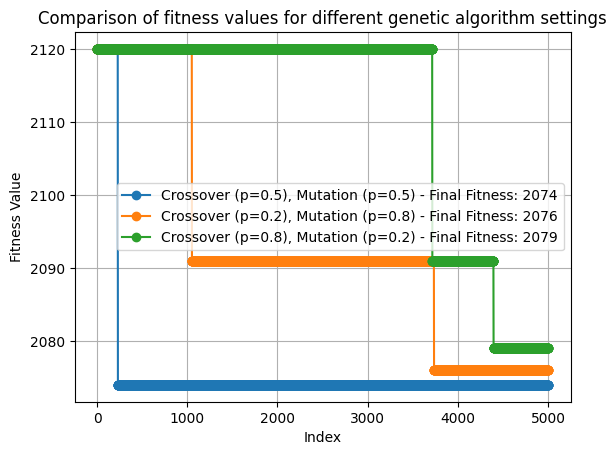

In [ ]:
plt.plot(fitness_count, label='Crossover (p=0.5), Mutation (p=0.5) - Final Fitness: {}'.format(fitness_count[-1]), marker='o')
plt.plot(fitness_count_mutation, label='Crossover (p=0.2), Mutation (p=0.8) - Final Fitness: {}'.format(fitness_count_mutation[-1]), marker='o')
plt.plot(fitness_count_crossover, label='Crossover (p=0.8), Mutation (p=0.2) - Final Fitness: {}'.format(fitness_count_crossover[-1]), marker='o')

plt.xlabel('Index')
plt.ylabel('Fitness Value')
plt.title('Comparison of fitness values for different genetic algorithm settings')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def gaant_plot(machine_lists, gaant, final_end_time):

    df = pd.DataFrame(gaant)
    fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")
    for i, row in df.iterrows():
        ax.barh(
            y=row["Machine"],
            width=row["Task"][0],
            left=row["Start Time"],
            color=row["Color"]
            )
    ax.set_title(f"Gaant chart")
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_yticks(np.arange(1, len(machine_lists) + 1))
    ax.grid(axis="x")
    plt.show()
    print("Total working time:", final_end_time)

##Final result:


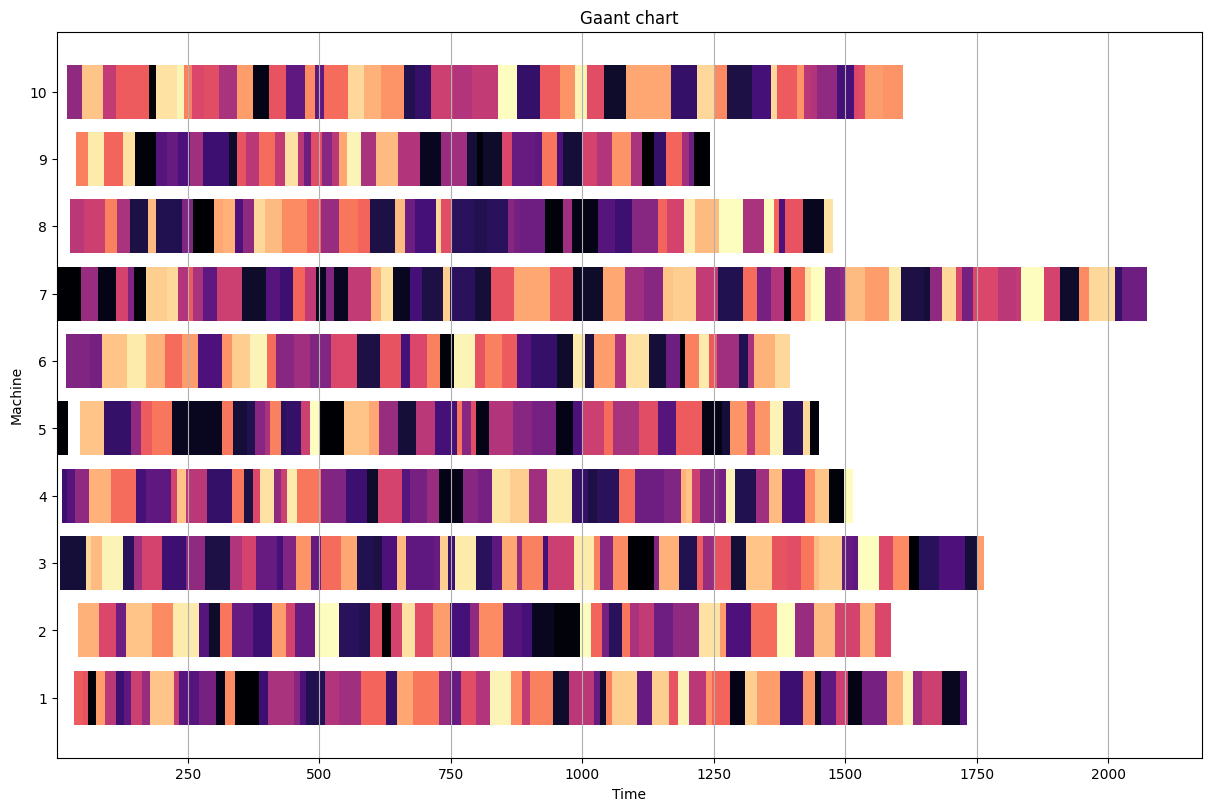

Total working time: 2074


In [ ]:
gaant, final_end_time  = fitness(final_plan)
gaant_plot(final_plan, gaant, final_end_time)